# Titanic survival status prediction - student runnable version

Modified version of Titanic survival predictor, where markdown is prettier and code blocks have additional comments in it.

## Building a Simple Pipeline

Let’s build a classifier for the Titanic data set, which describes the survival status of passengers on the Titanic,  
given different features such as their age and which class of the ship they embarked on.  
Prediction is based on RandomForestClassifier in this case.

In [2]:
import numpy as np
import pandas as pd 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import fetch_openml

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


## ColumnTransfomer

We often need to apply different transformations to different features (or subsets of features) in our data set.  
For example, categorical features typically require different transformations than numerical features (such as one-hot encoding).

The basic pipeline in Scikit-Learn does not allow you to apply a transformer to only a subset of the features.  
However, you can combine it with another class called ColumnTransformer, which allows different subsets of features  
to be transformed separately, and then concatenates them to form a single feature set.

For example, let’s build a classifier for the Titanic data set, which describes the survival status of passengers  
on the Titanic, given different features such as their age and which class of the ship they embarked on.

First, we fetch the data set using the fetch_openml() function:

In [3]:
# fetch titanic dataset
X, y = fetch_openml('titanic', version=1, return_X_y=True, as_frame=True, parser='auto')

In [4]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: category
Categories (2, object): ['0', '1']

In [5]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Features

X:
- Pclass Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name Name
- sex Sex
- age Age
- sibsp Number of Siblings/Spouses Aboard
- parch Number of Parents/Children Aboard
- ticket Ticket Number
- fare Passenger Fare (British pound)
- cabin Cabin
- embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- boat Lifeboat
- body Body Identification Number
- home.dest Home/Destination

y:
- survival Survival (0 = No; 1 = Yes)


In [6]:
X.shape, y.shape

((1309, 13), (1309,))

In [11]:
# Note! just numerical values included
# X.describe()
X.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292
body,121.0,160.809917,97.696922,1.0000,72.0000,155.0000,256.000,328.0000


In [12]:
y

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: category
Categories (2, object): ['0', '1']

In [13]:
# Check column names
X.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [14]:
# Check nulls on each column
X.isnull().sum()

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [15]:
# Check data types of different columns
X.dtypes

pclass          int64
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

As can be seen, some of the features in this data set are categorical, such as sex, embarked and class. We also have some columns with missing values, such as boat and body.

Therefore, we need to apply different transformations to different features in this data set. For the numerical features, we will apply the following transformations:

- Imputation of missing values using SimpleImputer with strategy = ‘mean’ (i.e., using the mean of the column to fill in the missing values).
- Normalization using a StandardScaler.

For the categorical features, we will apply the following transformations:

- Imputation of missing values using SimpleImputer with strategy = ‘most_frequent’.
- A OneHotEncoder transformation that encodes each label as an all-zeros vector with a 1 in the place of the label index.


First, we identify the numerical and categorical features and place them in two different lists (we use the fact that the categorical column have a data type of either ‘object’ or ‘category’):

In [16]:
# Split columns to numerical and categorial based on feature type
numerical_features = list(X.dtypes[(X.dtypes != 'object') & (X.dtypes != 'category')].index)
categorical_features = list(X.dtypes[(X.dtypes == 'object') | (X.dtypes == 'category')].index)

print('Numerical features:', numerical_features)
print('Categorical features:', categorical_features)

Numerical features: ['pclass', 'age', 'sibsp', 'parch', 'fare', 'body']
Categorical features: ['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest']


In [17]:
print(X[numerical_features])
print(X[categorical_features])

      pclass      age  sibsp  parch      fare   body
0          1  29.0000      0      0  211.3375    NaN
1          1   0.9167      1      2  151.5500    NaN
2          1   2.0000      1      2  151.5500    NaN
3          1  30.0000      1      2  151.5500  135.0
4          1  25.0000      1      2  151.5500    NaN
...      ...      ...    ...    ...       ...    ...
1304       3  14.5000      1      0   14.4542  328.0
1305       3      NaN      1      0   14.4542    NaN
1306       3  26.5000      0      0    7.2250  304.0
1307       3  27.0000      0      0    7.2250    NaN
1308       3  29.0000      0      0    7.8750    NaN

[1309 rows x 6 columns]
                                                 name     sex  ticket  \
0                       Allen, Miss. Elisabeth Walton  female   24160   
1                      Allison, Master. Hudson Trevor    male  113781   
2                        Allison, Miss. Helen Loraine  female  113781   
3                Allison, Mr. Hudson Joshua Cre

Define a pipeline for the numerical features:

In [19]:
# Create a transformer to numerical columns
# simpleInputer replaces NaN values
# standardScaler makes SD for all 1
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

...and another pipeline for the categorical features:

In [23]:
# Create a transformer to categorial columns
# simple inputer fills missing values with most_frequent
# OneHotEncoder transform categorical values into one hot binary value matrix
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

...finally create a ColumnTransformer that combines both pipelines, and associates each pipeline with its corresponding set of features:


In [24]:
# Create a preprocessor
preprocessor = ColumnTransformer([
    ('numerical', numerical_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_features)
])
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['pclass', 'age', 'sibsp', 'parch', 'fare',
                                  'body']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['name', 'sex', 'ticket', 'cabin', 'embarked',
                                  'boat', 'home.dest'])])

Next, create a pipeline that combines the column transformer and estimator (RandomForestClassifier).

In [ ]:
# Bolt together a preprocessor and then the classifier into one step
# pipeline combines preprocessor and classifier into one entity
# pre is name for preprocessor, and clf is name for classifier
# in this case we use RandomForestClassifier
pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier())
])

pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare', 'body']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['name', 'sex', 'ticket',
                                                   'cabin', 'embarked', 'boat',
                                                   'home.dest'])])),
                ('clf', RandomForestClassifier())])

Split the data set into training and test sets, train the model on the training set and evaluate it on the test set:

In [44]:
# Split the dataset and train the model
# in python, data is handled separately for predictors (X) and predicted (y)
# pipeline makes easier to manage data, because it handles both data transforming and machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline.fit(X_train, y_train)



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare', 'body']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['name', 'sex', 'ticket',
                                                   'cabin', 'embarked', 'boat',
                                                   'home.dest'])])),
                ('clf', RandomForestClassifier())])

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1047, 13), (1047,), (262, 13), (262,))

In [ ]:
# Print the accuracy of train and test sets
# value 1.0 training accurasy means training data has been learned correctly
# value 0.9847 means model also fits well to testing data
print('Training set accuracy:', np.round(pipeline.score(X_train, y_train), 4))
print('Test set accuracy:' , np.round(pipeline.score(X_test, y_test), 4))

Training set accuracy: 1.0
Test set accuracy: 0.9847


In [54]:
# Make predictions
# first predict y using the model and save predictions into y_pred
# after that, compare y_pred to test data's real y values to see
# if predictions were correct
y_pred = pipeline.predict(X_test)

In [55]:
# returns names of classes regocnizes by treemodel
# print 0 and 1 means, did person survive or not
print(f"Model classes: {pipeline.classes_}")

Model classes: ['0' '1']


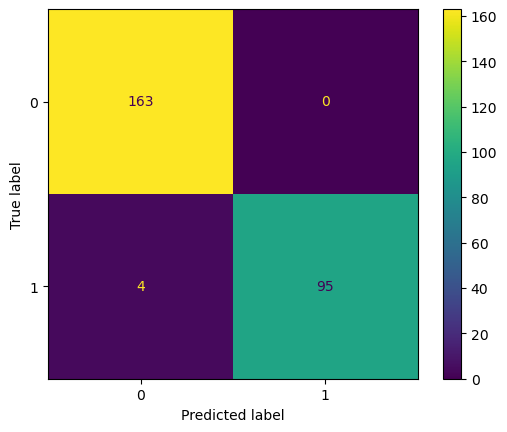

In [56]:
# Visualize the test prediction using confusion matrix aka "sekaannusmatriisi"
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# labels are names of classes the model regocnizes
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipeline.classes_)
disp.plot()
plt.show()


In [40]:
# Piirrä päätöspuu
"""

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

estimator = pipeline.named_steps['classifier'].estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(estimator, feature_names=numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)), class_names=pipeline.classes_.astype(str), filled=True)
plt.show()
"
"""


'\n\nfrom sklearn.tree import plot_tree\nimport matplotlib.pyplot as plt\n\nestimator = pipeline.named_steps[\'classifier\'].estimators_[0]\nplt.figure(figsize=(20,10))\nplot_tree(estimator, feature_names=numerical_features + list(pipeline.named_steps[\'preprocessor\'].transformers_[1][1].named_steps[\'onehot\'].get_feature_names_out(categorical_features)), class_names=pipeline.classes_.astype(str), filled=True)\nplt.show()\n"\n'